# Packages and Functions

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
warnings.filterwarnings('ignore')

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# Set Options

In [3]:
iB = 6
iB2 = 5
tplot = 0
tsnap = 1

In [4]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

# Set Grid

In [5]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
# hFacCpartial = mygrid['hFacC']
# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
print(hf1.shape)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)
(1, 1350, 270)


# Read mskBasin and Gateways

In [58]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


In [10]:

# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [11]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

LwetC2d 146614
LwetC 4833023


In [12]:
# load the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    #mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    # print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    # print(num,label)
    num += 1

# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

# Read fields of interest

In [13]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [14]:
# we want temperature and salt
THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)

for i in range(len(tsstr)):

    # read the fldList
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
    SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

In [15]:
# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [16]:
# get velocity fields
# read timesteps at index 1 and 3
UVELMASS = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
VVELMASS = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
# ADVx_TH = np.full((2,nz,ny,nx),np.nan)
# ADVy_TH = np.full((2,nz,ny,nx),np.nan)
# DFxE_TH = np.full((2,nz,ny,nx),np.nan)
# DFyE_TH = np.full((2,nz,ny,nx),np.nan)
# ADVx_SLT = np.full((2,nz,ny,nx),np.nan)
# ADVy_SLT = np.full((2,nz,ny,nx),np.nan)
# DFxE_SLT = np.full((2,nz,ny,nx),np.nan)
# DFyE_SLT = np.full((2,nz,ny,nx),np.nan)

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
# start from 1 because these are averages
for i in range(0,len(tsstr)-1):

    meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[i+1] + '.meta')
    fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
    varnames = np.array(['UVELMASS','VVELMASS','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    UVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[0])       # m/s
    VVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[1])       # m/s
    # ADVx_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[2])       # m/s
    # ADVy_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[3])       # m/s
    # DFxE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[4])       # m/s
    # DFyE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[5])       # m/s
    # ADVx_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[6])       # m/s
    # ADVy_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[7])       # m/s
    # DFxE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[8])       # m/s
    # DFyE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[9])       # m/s
    
    # reshaping and fixing up
    UVELMASS[i,:,:,:] = UVELMASSi.reshape(nz,ny,nx)
    VVELMASS[i,:,:,:] = VVELMASSi.reshape(nz,ny,nx)
    # ADVx_TH[ii,:,:,:] = ADVx_THi.reshape(nz,ny,nx)
    # ADVy_TH[ii,:,:,:] = ADVy_THi.reshape(nz,ny,nx)
    # DFxE_TH[ii,:,:,:] = DFxE_THi.reshape(nz,ny,nx)
    # DFyE_TH[ii,:,:,:] = DFyE_THi.reshape(nz,ny,nx)
    # ADVx_SLT[ii,:,:,:] = ADVx_SLTi.reshape(nz,ny,nx)
    # ADVy_SLT[ii,:,:,:] = ADVy_SLTi.reshape(nz,ny,nx)
    # DFxE_SLT[ii,:,:,:] = DFxE_SLTi.reshape(nz,ny,nx)
    # DFyE_SLT[ii,:,:,:] = DFyE_SLTi.reshape(nz,ny,nx)

In [17]:
# get the vectors of u and v without mass weighting
Uo = np.full((int(len(tsstr)-1),nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((int(len(tsstr)-1),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)-1))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]

    # get the vectors defined above
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo

# Get bathymetry and gateways oriented

In [18]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
cmaps = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

In [19]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)[0]

In [20]:
x1 = gg['FramStrait']["ix"]-1   # 1
y1 = gg['FramStrait']["jy"]-1

x2 = gg['BarentsSeaOpening']["ix"]-1   # 0 
y2 = gg['BarentsSeaOpening']["jy"]-1
x2[x2 == 162] = 161

test = np.full(mskBasin.shape,np.nan)
test[y1,x1] = 1
test[y2,x2] = 2

(420.0, 600.0)

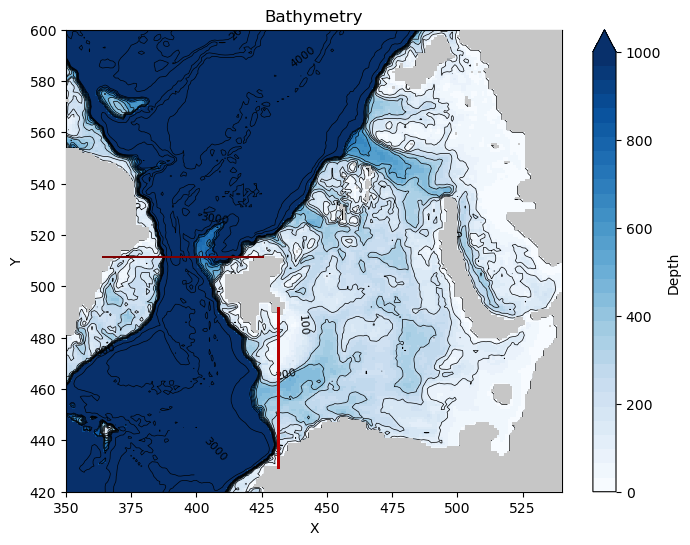

In [21]:
# plt.quiver(X, Y, u, v, color='r', scale=1, width=0.005)
x = np.arange(0,540,1)
y = np.arange(0,900,1)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(8, 6))
# Levels every 100 meters from 0 to 1000 and every 1000 meters from 1000 upwards
levels = np.concatenate([np.arange(0, 1000, 100), np.arange(1000, 6000, 1000)])
pcolor_plot = plt.pcolor(X, Y, get_aste_tracer(DD,nfx,nfy)[0], shading='auto',vmax=1000,cmap=cmap_bath)
# Add colorbar
cbar = plt.colorbar(pcolor_plot, label='Depth',extend="max")
# Add contour lines
contour_lines = plt.contour(X, Y, get_aste_tracer(DD,nfx,nfy)[0], levels=levels, colors='black', linewidths=0.5)
plt.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
plt.pcolormesh(get_aste_tracer(test,nfx,nfy)[0],vmax=10,zorder=8,cmap="seismic_r")
# Add labels to the contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
# Add title and axis labels
plt.title('Bathymetry')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(350,540)
plt.ylim(420,600)

# plt.savefig(path + "Barents_bathymetry.png",dpi=300)

# Plot the gateway

In [22]:
gateid = 1
m = 5  # month
x_curr,y_curr = x1,y1
mygate = np.where(get_aste_tracer(test,nfx,nfy)[0] ==gateid)

In [23]:
# plot bathymetry, velocity, temp profile, salt profile, density profile
# we need to get the perpendicular flow to the indicated gate
# define a function that looks to see if we are going lr or ud for each time
# if lr - perpendicular would be ud - y direction, vvelmass
# if ud - perpendicular would be lr - x direction, uvelmass
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations

choose_UV = line_orientation(mygate[1],mygate[0])
choose_UV = np.tile(choose_UV,(nz,1))
choose_UV[0].shape

(62,)

In [25]:
# try to isolate the areas along one gateway
gatemask = mygrid['hFacC'][:,y_curr,x_curr]
# this will be depth of cell * southern edge (mygrid['DXG']) if horizontal line or * western edge (mygrid['DYG']) if vertical)
dxggate = mygrid['DXG'][y_curr,x_curr]
dyggate = mygrid['DYG'][y_curr,x_curr]

# we make an array of the length of the cells
cell_lengths = np.full(choose_UV[0].shape[0],np.nan)
for i in range(len(choose_UV[0])):
    if choose_UV[0][i] == "V":
        cell_lengths[i] = dyggate[i] #DYG
    elif choose_UV[0][i] == "H":
        cell_lengths[i] = dxggate[i] #DXG

# print(np.nanmin(cell_lengths))
cell_lengths = np.tile(cell_lengths,(nz,1))
cell_area = cell_lengths * mygrid['DRF'].reshape(nz,1)

(-4500.0, 1.0)

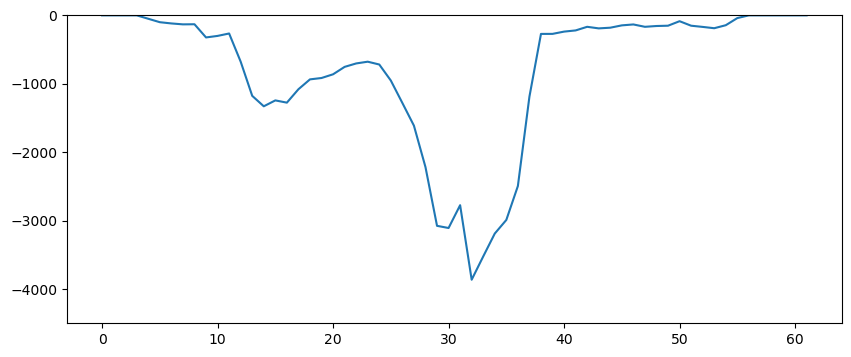

In [26]:
indices = np.arange(0,len(y_curr),1)
plt.plot(indices,-DD[y_curr,x_curr])
plt.ylim(-4500,1)
# ax.set_title("Bathymetry " + gate)

shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 62)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 62)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 62)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 62)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 62)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
c

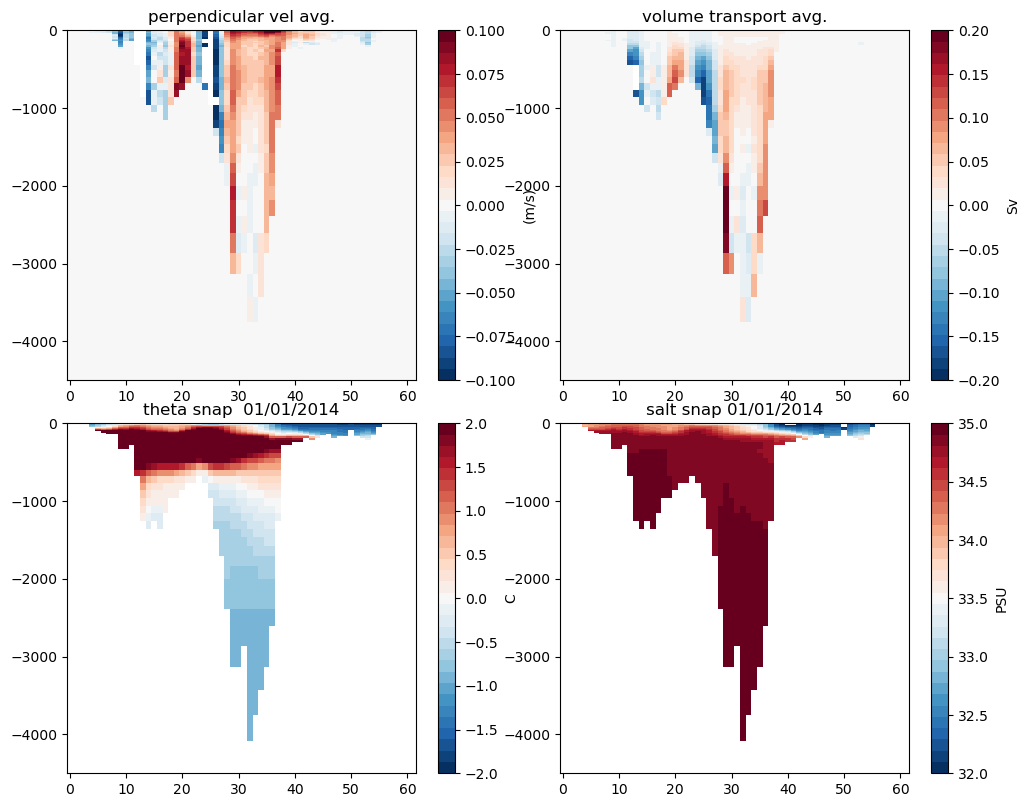

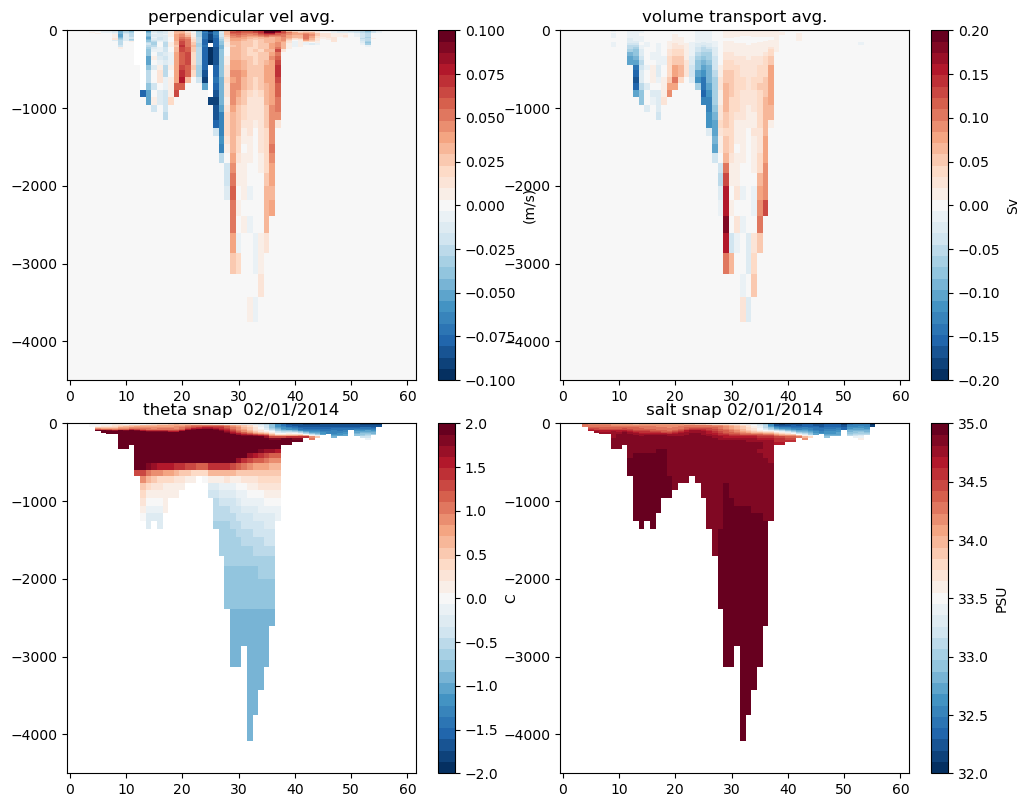

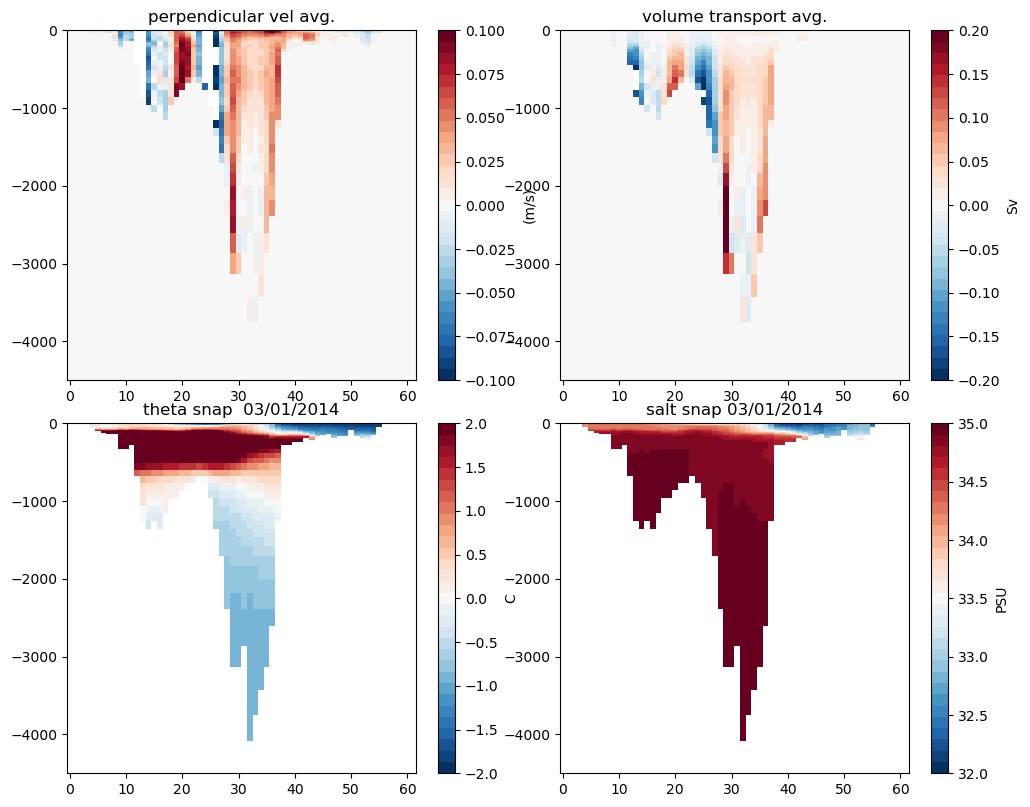

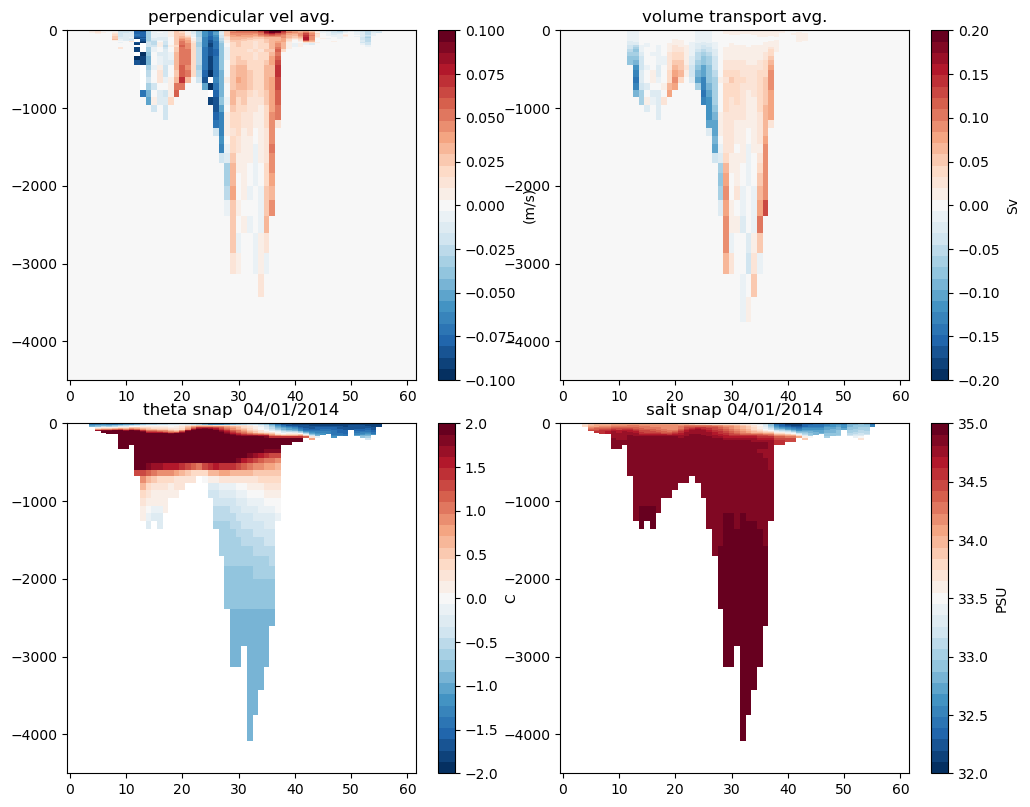

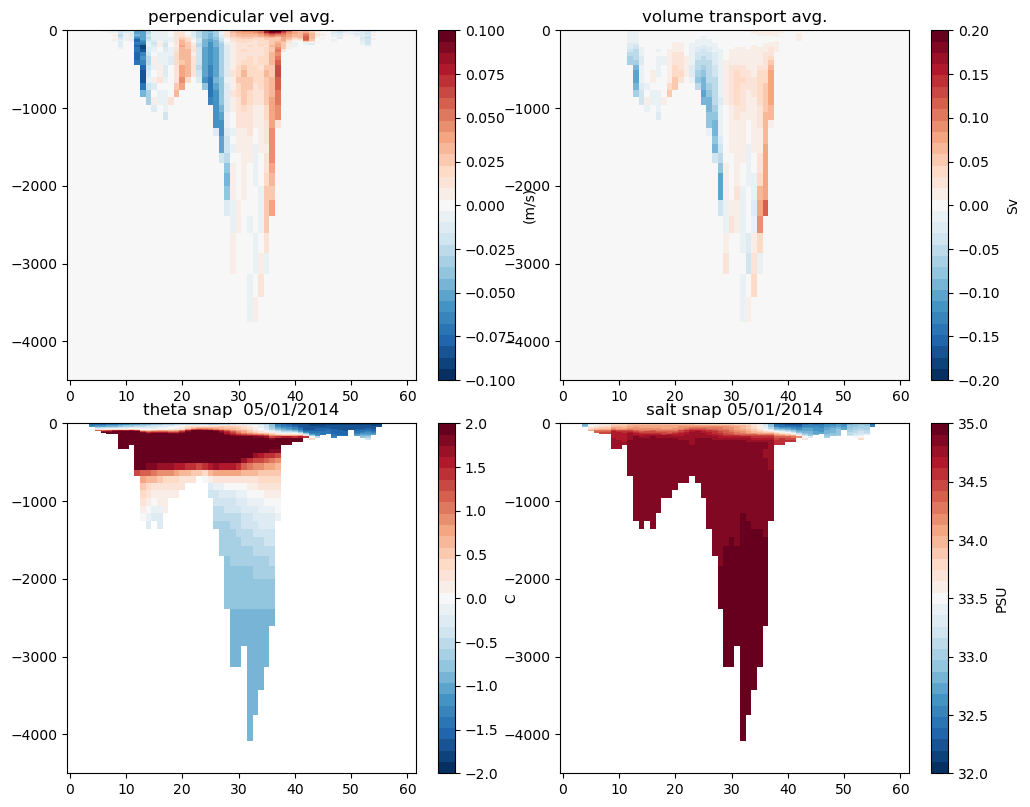

Error in callback <function flush_figures at 0x14a989eb2040> (for post_execute):


In [ ]:
gate = "FramStrait"
indices = np.arange(0,len(y_curr),1)

num_plots = 4
rows = 2
cols = 2

for m in range(len(tsstr)-1):

    # create the velocity - check since we changed the vvel and uvel
    uvelgate = aste_tracer2compact(Uo[m],nfx,nfy)
    vvelgate = aste_tracer2compact(Vo[m],nfx,nfy)
    
    uvelgate = uvelgate[:,y_curr,x_curr]
    vvelgate = vvelgate[:,y_curr,x_curr]
    
    perpendicular_vel = np.full(uvelgate.shape,np.nan) #    zeros_like(uvelgate)
    print(perpendicular_vel.shape)
    for i in range(len(choose_UV)):
        if choose_UV[i][0] == "V":
            perpendicular_vel[i] = uvelgate[i]       # flipping the sign of this helps reproduce An plot but this seems wrong??
        elif choose_UV[i][0] == "H":
            perpendicular_vel[i] = -vvelgate[i]
    fig,axes = plt.subplots(rows,cols,figsize=(10,8))
    fig.tight_layout(pad=1.0)

    # do plotting
    axes = axes.flatten()
    
    #########################
    # perpendicular vel into BaS
    ax = axes[0]
    XV,YV= np.meshgrid(indices,mygrid['RC'])
    cb = ax.pcolormesh(XV,YV,perpendicular_vel,cmap=cmap,vmin=-0.1,vmax=.1)
    ax.set_title("perpendicular vel avg.")
    ax.set_ylim(-4500,1)
    plt.colorbar(cb,label="(m/s)")
    
    
    #########################
    # volume is velocity * cell area
    ax = axes[1]
    cb = ax.pcolormesh(XV,YV,perpendicular_vel*cell_area*1e-6,cmap=cmap,vmin=-0.2,vmax=.2)
    ax.set_title("volume transport avg.")
    ax.set_ylim(-4500,1)
    plt.colorbar(cb,label="Sv")
    
    #########################
    # theta
    ax = axes[2]
    snaptheta = theta[m]
    cb = ax.pcolormesh(XV,YV,snaptheta[:,y_curr,x_curr],cmap=cmap,vmin=-2,vmax=2)
    ax.set_title("theta snap  "+ datetimes[m].strftime("%m/%d/%Y"))
    ax.set_ylim(-4500,1)
    plt.colorbar(cb,label="C")
    
    
    #########################
    # salt
    ax = axes[3]
    snapsalt = salt[m]
    cb = ax.pcolormesh(XV,YV,snapsalt[:,y_curr,x_curr],cmap=cmap,vmin=32,vmax=35)
    ax.set_title("salt snap "+ datetimes[m].strftime("%m/%d/%Y"))
    ax.set_ylim(-4500,1)
    plt.colorbar(cb,label="PSU")

    # save figure
    plt.savefig(path + gate + datetimes[m].strftime("%m%Y")+"gatetrsp.png",dpi=300)

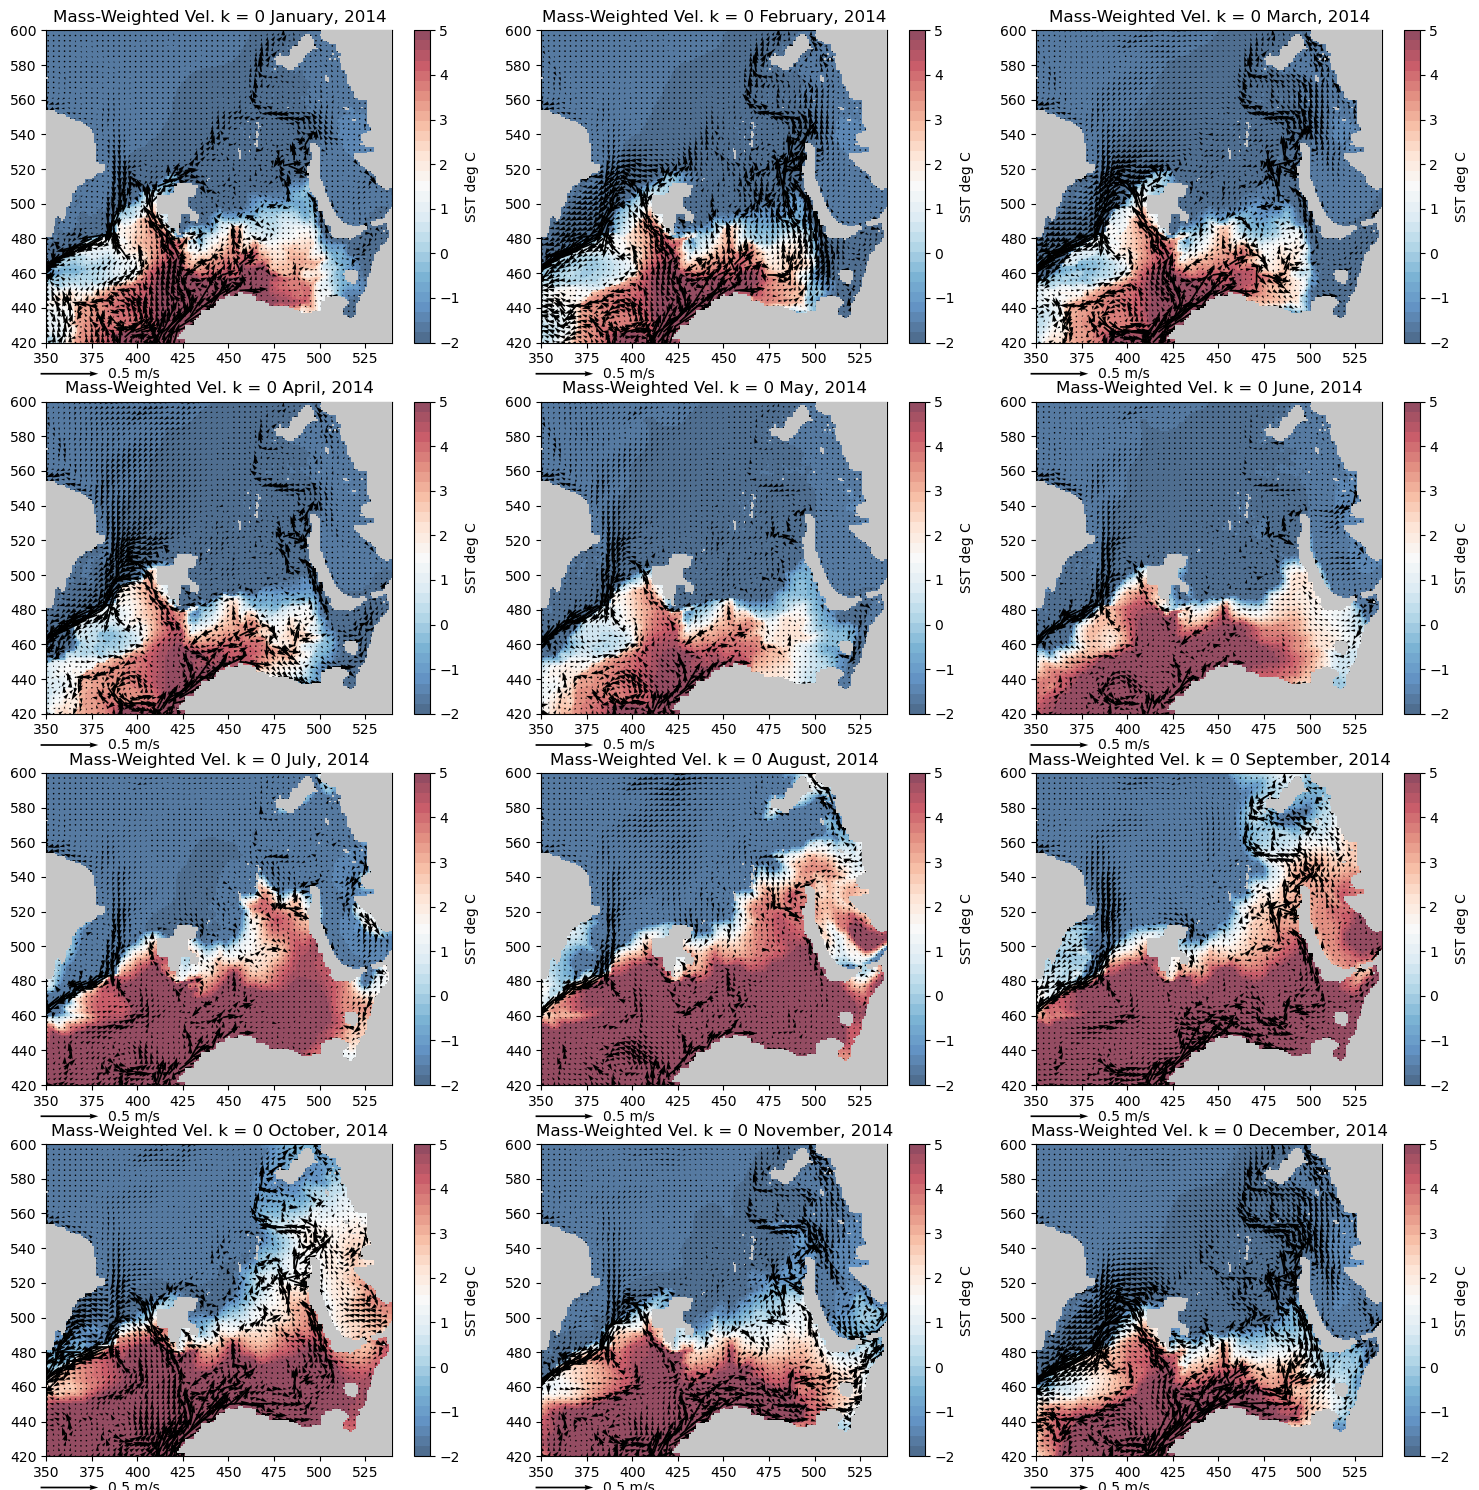

In [69]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
step=3

for t, ax in enumerate(axs.flat, start=0):
    #ax.text(0.5, 0.5, f"Plot {i}", fontsize=12, ha='center')
    cb = ax.pcolormesh(get_aste_tracer(theta[t],nfx,nfy)[0],cmap=cmap,vmin=-2,vmax=5,alpha=0.7)
    ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
    Q = ax.quiver(X[::step,::step], Y[::step,::step], Uo[t][0][::step,::step], Vo[t][0][::step,::step],scale=3,width=0.005,zorder=3)
    qk = ax.quiverkey(Q, X=0.15, Y=-0.1, U=0.5, label='0.5 m/s', labelpos='E')
    ax.set_title("Mass-Weighted Vel. k = 0 "+datetimes[t].strftime("%B, %Y"))
    ax.set_xlim(350,540)
    ax.set_ylim(420,600)
    plt.colorbar(cb,label="SST deg C")
    
plt.tight_layout()

plt.savefig(path + "trsp2014.png",dpi=300)
plt.show()

In [49]:
# look at horizontal difference in S across Fram Strait -difference in y axis

m = 2
snapsalt = salt[m,:,:,:]
snapsalt = get_aste_tracer(snapsalt,nfx,nfy)
snapsalt = snapsalt[:,1:,:] - snapsalt[:,:-1,:]   # differencing in y - gradient
snapsaltgrad_padded = np.pad(snapsalt, ((0, 0),(1, 0) ,(0, 0)), mode='constant', constant_values=0)

saltgrad = snapsaltgrad_padded / get_aste_tracer(mygrid["DYG"],nfx,nfy)

(420.0, 600.0)

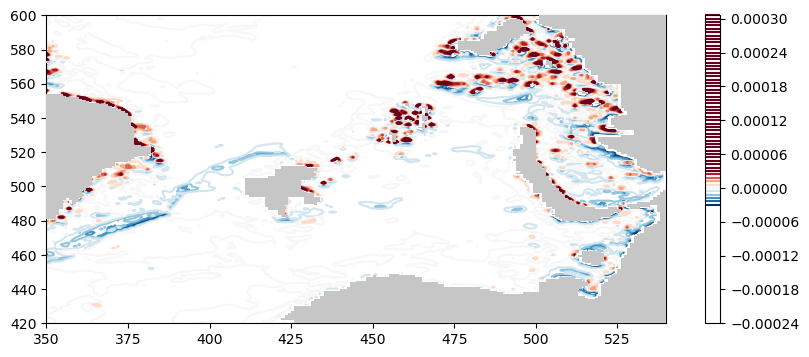

In [66]:
plt.contour(saltgrad[0],levels=100,cmap=cmap,vmin=-.00003,vmax=.00003)
plt.colorbar()
plt.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
plt.xlim(350,540)
plt.ylim(420,600)

In [1]:
# dens = gsw.rho(theta[:,0,:,:],salt[:,0,:,:],0)
# # do a plot of the surface lateral density gradient for all months
# fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# for t, ax in enumerate(axs.flat, start=0):
    
#     #ax.text(0.5, 0.5, f"Plot {i}", fontsize=12, ha='center')
#     cb = ax.pcolormesh(get_aste_tracer(dens[t],nfx,nfy)[0],cmap=cmap,vmin=1000,vmax=1025,alpha=0.7)
#     ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
#     ax.set_title("Surface Density "+datetimes[t].strftime("%B, %Y"))
#     ax.set_xlim(350,540)
#     ax.set_ylim(420,600)
#     plt.colorbar(cb,label="kg/m^3")
    
# plt.tight_layout()

# # plt.savefig(path + "trsp2014.png",dpi=300)
# plt.show()